> sentiment analysis VIA transformer

In [81]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import spacy
from textacy.preprocessing.replace import urls, hashtags, numbers, emails, emojis, currency_symbols
from textacy.preprocessing.remove import punctuation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras import optimizers

from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

from clr import LRFinder, OneCycleLR

In [5]:
data = pd.read_csv('./Data/steam_final.csv')
data.head()

,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
0,346110,ARK: Survival Evolved,34229965,english,"Great Game, terrible optimisation. Hopefully t...",1502693270,1502693270,False,5,0,...,True,False,True,76561198027465920,147,18,18112.0,1031.0,10328.0,1.611217e+09
1,583470,The End Is Nigh,33494894,english,Huh. I actually don't like it. I've 100%-ed ea...,1499918663,1500003674,False,374,6,...,True,False,False,76561198024153634,625,40,81.0,0.0,81.0,1.499918e+09
2,306130,The Elder Scrolls Online,38018491,english,very trashy talking about the tsev skyrim le,1512259531,1512259531,False,1,0,...,False,False,False,76561198372062226,67,2,2312.0,0.0,31.0,1.541884e+09
3,275850,No Man's Sky,24850717,english,Lag as shit,1471028227,1471028227,False,0,0,...,True,False,False,76561198123479228,47,2,28.0,0.0,28.0,1.471026e+09
4,271590,Grand Theft Auto V,33214384,english,Precarious policies.,1499142004,1499142004,False,4,0,...,True,False,False,76561197984388338,74,3,2332.0,0.0,2120.0,1.517301e+09


> encode label: `Recommended` -> `1`, `Not Recommended` -> `0`

In [6]:
data['label'] = np.ones(len(data))
data.loc[data['recommended']==False, 'label'] = 0

In [7]:
data = data[['review', 'label']]
data.head()

,review,label
0,"Great Game, terrible optimisation. Hopefully t...",0.0
1,Huh. I actually don't like it. I've 100%-ed ea...,0.0
2,very trashy talking about the tsev skyrim le,0.0
3,Lag as shit,0.0
4,Precarious policies.,0.0


In [8]:
data['review'].str.len().describe()

count    69909.000000
mean       302.586677
std        644.887908
min          1.000000
25%         26.000000
50%         91.000000
75%        291.000000
max       8000.000000
Name: review, dtype: float64

In [9]:
data[data['review'].isnull()]['label'].describe()

count    91.000000
mean      0.857143
std       0.351866
min       0.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: label, dtype: float64

drop NA reviews

In [10]:
data.dropna(how='any', inplace=True)
data.shape

(69909, 2)

drop duplicated reviews

In [11]:
data.drop_duplicates('review', inplace=True)
data.shape

(64249, 2)

In [56]:
data

,review,label
0,Great Game terrible optimisation Hopefully the...,0.0
1,Huh I actually don t like it I ve NUMBER ed e...,0.0
2,very trashy talking about the tsev skyrim le,0.0
3,Lag as shit,0.0
4,Precarious policies,0.0
...,...,...
69994,good game i like it,1.0
69995,It just runs really well and is super streamli...,1.0
69996,I like tthis game iot have gun and it have a b,1.0
69998,Bought it again for the 3rd time on PC had nor...,1.0


### text preprocess

#### clean text

In [12]:
data['review'] = data['review'].\
                  apply(urls).\
                  apply(hashtags).\
                  apply(numbers).\
                  apply(currency_symbols).\
                  apply(emojis).\
                  apply(emails)

In [13]:
data['review'] = data['review'].apply(punctuation)

In [14]:
data['review']

0        Great Game  terrible optimisation  Hopefully t...
1        Huh  I actually don t like it  I ve  NUMBER   ...
2             very trashy talking about the tsev skyrim le
3                                              Lag as shit
4                                     Precarious policies 
                               ...                        
69994                                  good game i like it
69995    It just runs really well and is super streamli...
69996       I like tthis game iot have gun and it have a b
69998    Bought it again for the 3rd time on PC  had no...
69999                   damn good game and super addicting
Name: review, Length: 64249, dtype: object

In [15]:
data['review'] = data['review'].str.replace("  ", " ", regex=True)
data['review'] = data['review'].str.replace(r'(<br />)', " ", regex=True)
data['review'] = data['review'].str.replace(r'[.!?\-\"\\]', ' ', regex=True)
data['review'] = data['review'].str.replace("\n", " ", regex=True)

In [16]:
data['review'] = data['review'].str.replace("EMOJI", "", regex=True)

#### removing stopwords

In [17]:
docs = data['review']
labels = data['label']

In [18]:
nlp = spacy.load('en_core_web_sm', disable=["ner", "tagger"])
words_set = set(nlp.vocab.strings)
docs_cleaned = list(
    map(lambda doc: " ".join([token.text for token in nlp(doc) 
                                      if (not token.is_stop) and (token.text in words_set)]), docs))

/Users/antheayang/opt/anaconda3/lib/python3.7/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [19]:
docs_cleaned

['Great Game terrible Hopefully fix instead trying cash grab',
 'Huh actually don t like ve   ed game Edmund ve fan minute End came quickly t expectations focus far precision Meat Boy s charm s fluidity speed precision miles minute far methodical drawn mention lot forced trial error pretty meh cartridges big ticket item merely stages lo fi graphics Music great s odd charm fact     public domain music rock Isaac graphics fantastic Controls perfect s self contained game map stage real yes backtrack world entirety search mileage   real charm bland color scheme world little variety waiting jumping right spot repeat opposed Meat Boy s dynamic levels far obstacles variety different mechanics speed kept things fresh End basically Meat Boy distilled main mechanics remove wall jumping sprint switch focus fluidity precision dull stages feel like change feel',
 'trashy talking le',
 'Lag shit',
 'policies',
 'liked game',
 'need Chinese party party Chinese experience Paradox Chinese localization 

leave only meaningful sentence AND remove extra white spaces

<div class="alert-danger">
remove sentences has problems with labels</div>

In [22]:
docs_cleaned = [re.sub(' +', ' ', i) for i in docs_cleaned]
# docs_cleaned = [sentence for sentence in docs_cleaned if len(sentence)>1]
docs_cleaned

['Great Game terrible Hopefully fix instead trying cash grab',
 'Huh actually don t like ve ed game Edmund ve fan minute End came quickly t expectations focus far precision Meat Boy s charm s fluidity speed precision miles minute far methodical drawn mention lot forced trial error pretty meh cartridges big ticket item merely stages lo fi graphics Music great s odd charm fact public domain music rock Isaac graphics fantastic Controls perfect s self contained game map stage real yes backtrack world entirety search mileage real charm bland color scheme world little variety waiting jumping right spot repeat opposed Meat Boy s dynamic levels far obstacles variety different mechanics speed kept things fresh End basically Meat Boy distilled main mechanics remove wall jumping sprint switch focus fluidity precision dull stages feel like change feel',
 'trashy talking le',
 'Lag shit',
 'policies',
 'liked game',
 'need Chinese party party Chinese experience Paradox Chinese localization hope Par

remove consecutively repeated patterns

In [23]:
docs_cleaned = [re.sub(r'^(.+?)\1+', r'\1', i) for i in docs_cleaned]

#### tokenize

<AxesSubplot:>

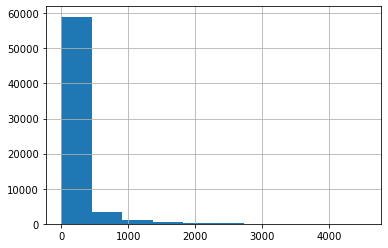

In [24]:
pd.Series(docs_cleaned).str.len().hist()

In [25]:
pd.Series(docs_cleaned).str.len().describe()

count    64249.000000
mean       156.162586
std        321.491420
min          0.000000
25%         17.000000
50%         51.000000
75%        153.000000
max       4544.000000
dtype: float64

> since 75% of the reviews are less than 157 words, set `MAX_SEQUENCE_LENGTH` to 256

In [26]:
tokenizer = Tokenizer(num_words=256, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(docs_cleaned)

In [27]:
def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

In [28]:
# integer encode the documents
docs_encoded = integer_encode_documents(docs_cleaned, tokenizer)

In [29]:
np.array(docs_encoded).shape

/Users/antheayang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(64249,)

In [31]:
docs_padded = pad_sequences(docs_encoded, maxlen=125, padding='post')
docs_padded

array([[ 12,   2, 167, ...,   0,   0,   0],
       [ 54,  11,   4, ...,   5, 153,  37],
       [  1,   1,   1, ...,   0,   0,   0],
       ...,
       [  5,   2,   1, ...,   0,   0,   0],
       [108,   1,   9, ...,   0,   0,   0],
       [  1,   7,   2, ...,   0,   0,   0]], dtype=int32)

In [32]:
docs_padded.shape

(64249, 125)

In [33]:
vocab_size = int(len(tokenizer.word_index) * 1.3)
print(f"Vocab size is {vocab_size} unique tokens.")

Vocab size is 27766 unique tokens.


In [55]:
data_emb = pd.DataFrame(docs_padded)
data_emb

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,12,2,167,1,72,117,104,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,54,11,4,5,16,1,2,1,16,219,...,1,1,1,1,1,1,37,5,153,37
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,69,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64244,7,2,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64245,1,217,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64246,5,2,1,1,82,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64247,108,1,9,86,1,1,1,1,1,171,...,0,0,0,0,0,0,0,0,0,0


In [61]:
data_emb = pd.concat([data_emb.reset_index(drop=True),
                      data.reset_index(drop=True)], axis=1, ignore_index=True)

In [62]:
data_emb.to_csv('./Data/steam_embeded.csv')

### model

In [137]:
EMBEDDING_SIZE = 64

> too many params -> easily overfit

In [142]:
# define the model
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=docs_padded.shape[1]))
model.add(Flatten()) 

# model.add(Dense(256, activation='sigmoid')) 
# model.add(Dense(128, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

opt = optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
# summarize the model
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 125, 64)           1777024   
_________________________________________________________________
flatten_29 (Flatten)         (None, 8000)              0         
_________________________________________________________________
dense_86 (Dense)             (None, 64)                512064    
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 65        
Total params: 2,289,153
Trainable params: 2,289,153
Non-trainable params: 0
_________________________________________________________________


In [48]:
X_train, X_test, y_train, y_test = train_test_split(docs_padded, labels, test_size=0.2, random_state=41)
X_train.shape, X_test.shape

((51399, 125), (12850, 125))

> try to use One-Cycle Policy to accelerate training, yet it doesn't comply with `Adam` optimizer, which has much better performance compared to `SGD`.

In [143]:
BATCH_SIZE = 64

##### lr_finder

In [124]:
lr_callback = LRFinder(num_samples=len(X_train), batch_size=BATCH_SIZE,
#                         minimum_lr, maximum_lr,
                       # validation_data=(X_val, Y_val),
                       lr_scale='linear')

# Ensure that number of epochs = 1 when calling fit()
model.fit(X_train, y_train, epochs=1, batch_size=BATCH_SIZE, callbacks=[lr_callback], verbose=1)

Epoch 1/1
 1056/51399 [..............................] - ETA: 2:11 - loss: 0.7122 - acc: 0.5303 - LRFinder: lr = 0.19926260 


KeyboardInterrupt: 

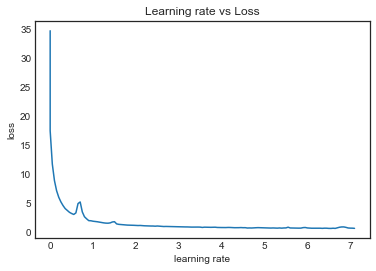

In [79]:
lr_callback.plot_schedule()

#### training

In [144]:
# fit the model
es = EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=1)
# lr_manager = OneCycleLR(num_samples=len(X_train), batch_size=BATCH_SIZE, max_lr=1e-2,
#                         end_percentage=0.1, scale_percentage=None,
#                         maximum_momentum=0.95, minimum_momentum=0.85)
                        
log = model.fit(X_train, y_train, batch_size=BATCH_SIZE, validation_split=0.1, 
#                 epochs=50, verbose=1, callbacks=[es, lr_manager])
                epochs=50, verbose=1, callbacks=[es])

Train on 46259 samples, validate on 5140 samples
Epoch 1/50
46259/46259 [==============================] - 49s 1ms/step - loss: 0.5190 - acc: 0.7324 - val_loss: 0.5397 - val_acc: 0.7418
Epoch 2/50
46259/46259 [==============================] - 49s 1ms/step - loss: 0.4923 - acc: 0.7482 - val_loss: 0.5268 - val_acc: 0.7276
Epoch 3/50
46259/46259 [==============================] - 49s 1ms/step - loss: 0.4914 - acc: 0.7459 - val_loss: 0.5141 - val_acc: 0.7346
Epoch 4/50
46259/46259 [==============================] - 49s 1ms/step - loss: 0.4842 - acc: 0.7512 - val_loss: 0.5084 - val_acc: 0.7362
Epoch 5/50
46259/46259 [==============================] - 49s 1ms/step - loss: 0.4825 - acc: 0.7532 - val_loss: 0.5070 - val_acc: 0.7329
Epoch 6/50
46259/46259 [==============================] - 49s 1ms/step - loss: 0.4792 - acc: 0.7564 - val_loss: 0.5046 - val_acc: 0.7387
Epoch 7/50
46259/46259 [==============================] - 49s 1ms/step - loss: 0.4773 - acc: 0.7559 - val_loss: 0.5096 - val_acc:

In [145]:
# evaluate the model
loss_tr, acc_tr = model.evaluate(X_train, y_train, verbose=1)
print('TRAIN Accuracy: %f' % (acc_tr*100))
loss_tt, acc_tt = model.evaluate(X_test, y_test, verbose=1)
print('TEST Accuracy: %f' % (acc_tt*100))

51399/51399 [==============================] - 13s 258us/step
TRAIN Accuracy: 75.625986
12850/12850 [==============================] - 3s 258us/step
TEST Accuracy: 74.093384


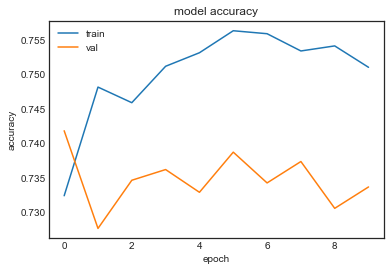

In [146]:
plot_fit_history(log)

In [135]:
# evaluate the model
loss_tr, acc_tr = model.evaluate(X_train, y_train, verbose=1)
print('Accuracy: %f' % (acc_tr*100))

51399/51399 [==============================] - 146s 3ms/step
Accuracy: 79.318666


In [104]:
def plot_fit_history(log):
    plt.plot(log.history['acc'])
    plt.plot(log.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

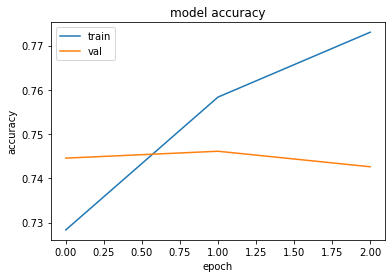

In [138]:

plot_fit_history(log)

#### testing

In [139]:
loss_tt, acc_tt = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (acc_tt*100))

12850/12850 [==============================] - 36s 3ms/step
Accuracy: 75.322956
